# Unsupervised NLP Capstone
----

In [1]:
import numpy as np
import pandas as pd
import sklearn
import os
from sklearn.cluster import KMeans
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import re
import scipy
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_pipeline
from sklearn.cluster import SpectralClustering
import nltk
import scipy.stats as stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
import glob
from sklearn import ensemble
import requests 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import gutenberg, stopwords
from collections import Counter
%matplotlib inline

In [2]:
english_stops = stopwords.words('english')
nlp = spacy.load('en')

### Training Set

In [3]:
path = "./data/20news-bydate/20news-bydate-train/"
df_news = pd.DataFrame(columns=['text', 'category'])

allGraphicsFiles = glob.glob(path + 'graphics' + "/*")
allWindowsMiscFiles = glob.glob(path + 'windows_misc' + "/*")
allPcHardwareFiles = glob.glob(path + 'pc_hardware' + "/*")
allMacHardwareFiles = glob.glob(path + 'mac_hardware' + "/*")
allWindowsXFiles = glob.glob(path + 'windows_x' + "/*")
allCryptFiles = glob.glob(path + 'crypt' + "/*")
allElectronicsFiles = glob.glob(path + 'electronics' + "/*")
allMedFiles = glob.glob(path + 'med' + "/*")
allSpaceFiles = glob.glob(path + 'space' + "/*")
allPoliticsFiles = glob.glob(path + 'politics' + "/*")

allFiles = (allGraphicsFiles + 
            allWindowsMiscFiles + 
            allPcHardwareFiles + 
            allMacHardwareFiles + 
            allWindowsXFiles + 
            allCryptFiles + 
            allElectronicsFiles + 
            allMedFiles + 
            allSpaceFiles + 
            allPoliticsFiles)

# for file_ in allFiles:
for idx, file_ in enumerate(allFiles):
    with open(file_, 'r', encoding='utf-8', errors='ignore') as myfile:
        data = myfile.read()
                
        # Grab label from the directory name
        labelFromDir = re.split(r'\/', allFiles[idx])[-2]     
        
        df_news = df_news.append({'text': data, 'category': labelFromDir}, ignore_index=True)

### Test set

In [4]:
path = "./data/20news-bydate/20news-bydate-test/"
df_news_test = pd.DataFrame(columns=['text', 'category'])

allGraphicsFiles = glob.glob(path + 'graphics' + "/*")
allWindowsMiscFiles = glob.glob(path + 'windows_misc' + "/*")
allPcHardwareFiles = glob.glob(path + 'pc_hardware' + "/*")
allMacHardwareFiles = glob.glob(path + 'mac_hardware' + "/*")
allWindowsXFiles = glob.glob(path + 'windows_x' + "/*")
allCryptFiles = glob.glob(path + 'crypt' + "/*")
allElectronicsFiles = glob.glob(path + 'electronics' + "/*")
allMedFiles = glob.glob(path + 'med' + "/*")
allSpaceFiles = glob.glob(path + 'space' + "/*")
allPoliticsFiles = glob.glob(path + 'politics' + "/*")

allTestFiles = (
            allGraphicsFiles + 
            allWindowsMiscFiles + 
            allPcHardwareFiles + 
            allMacHardwareFiles + 
            allWindowsXFiles + 
            allCryptFiles + 
            allElectronicsFiles +
            allMedFiles + 
            allSpaceFiles + 
            allPoliticsFiles)

# for file_ in allFiles:
for idx, file_ in enumerate(allTestFiles):
    with open(file_, 'r', encoding='utf-8', errors='ignore') as myfile:
        data = myfile.read() 
        
        # Grab label from the directory name
        labelFromDir = re.split(r'\/', allTestFiles[idx])[-2]
        
        df_news_test = df_news_test.append({'text': data, 'category': labelFromDir}, ignore_index=True)

In [5]:
# Train set
print(f'df_news.shape: {df_news.shape}')
df_news.head()

df_news.shape: (5774, 2)


,text,category
0,From: cavalier@blkbox.COM (Bill Egan)\nSubject...,graphics
1,From: ch381@cleveland.Freenet.Edu (James K. Bl...,graphics
2,From: rytg7@fel.tno.nl (Q. van Rijt)\nSubject:...,graphics
3,From: uk02183@nx10.mik.uky.edu (bryan k willia...,graphics
4,From: rschmitt@shearson.com (Robert Schmitt)\n...,graphics


In [6]:
df_news['category'].value_counts()

crypt           595
med             594
space           593
windows_x       593
electronics     591
windows_misc    591
pc_hardware     590
graphics        584
mac_hardware    578
politics        465
Name: category, dtype: int64

In [7]:
# Test set
print(f'df_news_test.shape: {df_news_test.shape}')
df_news_test.head()

df_news_test.shape: (3844, 2)


,text,category
0,From: Scott_Rindfleisch@vos.stratus.com\nSubje...,graphics
1,From: SITUNAYA@IBM3090.BHAM.AC.UK\nSubject: Be...,graphics
2,From: z_nixsp@ccsvax.sfasu.edu\nSubject: Re: T...,graphics
3,From: vax839@tid.es (Juan Carlos Cuesta Cuesta...,graphics
4,From: dts@buoy.cis.ufl.edu (Dave Small)\nSubje...,graphics


In [8]:
df_news_test['category'].value_counts()

crypt           396
med             396
windows_x       395
space           394
windows_misc    394
electronics     393
pc_hardware     392
graphics        389
mac_hardware    385
politics        310
Name: category, dtype: int64

## Preprocessing

In [9]:
def texter(text):
    # Remove special chars
    document = re.sub(r'\W', ' ', text)
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 

    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    tokens = [w for w in word_tokenize(document.lower()) 
                  if w.isalpha()]
    
    no_stops = [t for t in tokens 
                    if t not in english_stops]
    
    lemmatized = [WordNetLemmatizer().lemmatize(t) for t in no_stops]
    
    document = ' '.join(lemmatized)
    
    return document

In [10]:
# Before Preprocessing
df_news['text'][0]

"From: cavalier@blkbox.COM (Bill Egan)\nSubject: Re: Weitek P9000 ?\nNntp-Posting-Host: port3.houston.pub-ip.psi.net\nOrganization: Performance Systems Int'l\nLines: 13\n\njgreen@amber (Joe Green) writes:\n>> > Anyone know about the Weitek P9000 graphics chip?\n\n>Do you have Weitek's address/phone number?  I'd like to get some information\n>about this chip.\n\nYes, I am very interested in this chip.  Please follow up or email.\n\n--\nBill Egan          \nCavalier Graphics\nHouston, Texas\nEmail: cavalier@blkbox.com \n"

In [11]:
df_news['text'] = df_news['text'].apply(texter)
df_news_test['text'] = df_news_test['text'].apply(texter)

In [12]:
# After Preprocessing
df_news['text'][0]

'cavalier blkbox com bill egan subject weitek nntp posting host houston pub ip psi net organization performance system int line jgreen amber joe green writes anyone know weitek graphic chip weitek address phone number like get information chip yes interested chip please follow email bill egan cavalier graphic houston texas email cavalier blkbox com'

In [13]:
def mutlt_labels(row):
    if (row == 'crypt'):
        return 1
    elif (row == 'med'):
        return 2
    elif (row == 'windows_x'):
        return 3
    elif (row == 'space'):
        return 4
    elif (row == 'electronics'):
        return 5
    elif (row == 'windows_misc'):
        return 6
    elif (row == 'pc_hardware'):
        return 7
    elif (row == 'graphics'):
        return 8
    elif (row == 'mac_hardware'):
        return 9
    elif (row == 'politics'):
        return 10
    else:
        return row

In [14]:
df_news['category'] = df_news['category'].apply(mutlt_labels)
df_news_test['category'] = df_news_test['category'].apply(mutlt_labels)

In [15]:
df_news['category'].value_counts()

1     595
2     594
3     593
4     593
6     591
5     591
7     590
8     584
9     578
10    465
Name: category, dtype: int64

## BoW

In [52]:
# Initialize a CountVectorizer, min appearance of 5 docs
count_vectorizer = CountVectorizer(stop_words="english", min_df=5)

# Transform the training data
counts = count_vectorizer.fit_transform(df_news['text'].values)

# Transform the val data
# count_val = count_vectorizer.transform(X_val.values)

# Print the first 10 features
print(count_vectorizer.get_feature_names()[0:10])

['aa', 'aaron', 'aau', 'ab', 'abad', 'abandon', 'abandoned', 'abbey', 'abbreviation', 'abc']


## TF-IDF

In [53]:
# Initialize a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words="english", min_df=5)

# Transform the training data
tfidfs = tfidf_vectorizer.fit_transform(df_news['text'].values)

# Transform the validation data
# tfidf_val = tfidf_vectorizer.transform(X_val.values)

# Transform the test data
tfidf_test = tfidf_vectorizer.transform(X_test.values)

In [54]:
tfidfs.A

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Clustering

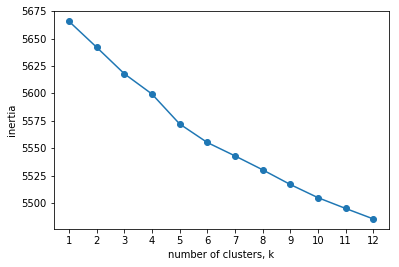

In [55]:
# Intertias
ks = range(1, 13)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(tfidfs)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

## SpectralClustering

In [112]:
n_clusters=10

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(tfidfs)

#Predicted clusters.
predict_sc = sc.fit_predict(tfidfs)

In [113]:
pd.crosstab(df_news['category'].values, predict_sc) 

col_0,0,1,2,3,4,5,6,7,8,9
category,,,,,,,,,,
1,9,16,214,17,0,0,1,2,187,0
2,24,0,357,0,58,0,2,4,0,0
3,50,0,228,0,0,0,158,5,4,0
4,13,0,220,0,0,0,0,212,0,0
5,141,0,282,0,0,0,3,17,0,0
6,131,0,90,0,0,0,221,1,0,0
7,287,0,101,0,0,36,16,0,2,0
8,142,0,237,0,0,0,52,7,0,0
9,324,0,97,0,0,8,2,3,0,0


In [114]:
metrics.adjusted_rand_score(y_train, predict_sc)

0.09408574389739935

Performed much worse than Kmeans

In [59]:
km = KMeans(n_clusters=6)

# Fit model to samples
km.fit(tfidfs)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [60]:
km_6_pred = km.predict(tfidfs)
metrics.adjusted_rand_score(df_news['category'].values, km_6_pred)

0.14700480080691355

In [61]:
km_10 = KMeans(n_clusters=10)
    
# Fit model to samples
km_10.fit(tfidfs)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [62]:
km_10_pred = km_10.predict(tfidfs)
metrics.adjusted_rand_score(df_news['category'].values, km_10_pred)

0.1521777275821829

## Add cluster feature

In [102]:
# X = pd.DataFrame()
# X = df_news.loc[:, ~df_news.columns.isin(['category'])]
y = df_news['category']
# X['cluster_number'] = km.labels_

tfidf_df = pd.DataFrame(tfidfs.A, columns=tfidf_vectorizer.get_feature_names())
tfidf_df.head()

,aa,aaron,aau,ab,abad,abandon,abandoned,abbey,abbreviation,abc,...,zrepachol,zt,zterm,zu,zurich,zv,zw,zy,zyeh,zz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
tfidf_df['cluster_number'] = km.labels_
tfidf_df.head()

,aa,aaron,aau,ab,abad,abandon,abandoned,abbey,abbreviation,abc,...,zt,zterm,zu,zurich,zv,zw,zy,zyeh,zz,cluster_number
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


## Train / Test splits

In [119]:
# Create training and test sets
X_tfidf_train, X_tfidf_val, y_tfidf_train, y_tfidf_val = train_test_split(tfidf_df, y, test_size=0.25, stratify=y, random_state=53)

# Test set
X_test = df_news_test['text']
y_test = df_news_test['category']

# Transform the test data
count_test = count_vectorizer.transform(X_test.values)
tfidf_test = tfidf_vectorizer.transform(X_test.values)

## Logistic Regression

In [110]:
# Instantiate
lr = LogisticRegression()

# Fit the classifier to the training data
lr.fit(X_tfidf_train, y_tfidf_train)

# Create the predicted tags: pred
pred = lr.predict(X_tfidf_val)

print('Training set score:', lr.score(X_tfidf_train, y_tfidf_train))

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_tfidf_val, pred)
print(f'\nTest set score: {score}')

# Calculate the confusion matrix: cm
pd.crosstab(y_tfidf_val, pred)

Training set score: 0.9540415704387991

Test set score: 0.8601108033240997


col_0,1,2,3,4,5,6,7,8,9,10
category,,,,,,,,,,
1,126,1,6,1,2,0,1,8,0,4
2,0,138,1,2,4,0,1,3,0,0
3,2,0,118,4,2,10,3,9,0,0
4,0,3,2,131,3,0,1,6,2,0
5,0,0,0,2,135,0,4,4,3,0
6,0,0,8,0,2,126,5,7,0,0
7,0,0,3,0,6,13,109,5,12,0
8,0,0,7,0,3,1,3,131,1,0
9,0,0,0,0,6,2,7,5,122,2


In [114]:
param_grid = {'C': [0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_tfidf_train, y_tfidf_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.88
Best parameters:  {'C': 10}


## Remove clustering feature

In [116]:
X_tfidf_train = X_tfidf_train.loc[:, ~X_tfidf_train.columns.isin(['cluster_number'])]
X_tfidf_val = X_tfidf_val.loc[:, ~X_tfidf_val.columns.isin(['cluster_number'])]

In [118]:
param_grid = {'C': [0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_tfidf_train, y_tfidf_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.89
Best parameters:  {'C': 10}


The models actually perform better without the clustering feature.

## Train set split and BOW

In [16]:
# Create training and test sets
X_train, X_val, y_train, y_val = train_test_split(df_news['text'], df_news['category'], test_size=0.25, stratify=df_news['category'], random_state=53)

# Initialize a CountVectorizer, min appearance of 5 docs
count_vectorizer = CountVectorizer(stop_words="english", min_df=5)

# Transform the training data
count_train = count_vectorizer.fit_transform(X_train.values)

# Transform the val data
count_val = count_vectorizer.transform(X_val.values)

# Print the first 10 features
print(count_vectorizer.get_feature_names()[0:10])

['aa', 'aaron', 'aau', 'ab', 'abandon', 'abandoned', 'abc', 'abiding', 'ability', 'able']


In [17]:
# Test set
X_test = df_news_test['text']
y_test = df_news_test['category']
count_test = count_vectorizer.transform(X_test.values)

In [18]:
print(f'count_test.shape: {count_test.shape}')
count_test.A

count_test.shape: (3844, 10252)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [19]:
print(f'count_train.shape: {count_train.shape}')
count_train.A

count_train.shape: (4330, 10252)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

## TF-IDF

In [45]:
# Initialize a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words="english", min_df=5)

# Transform the training data
tfidf_train = tfidf_vectorizer.fit_transform(X_train.values)

# Transform the validation data
tfidf_val = tfidf_vectorizer.transform(X_val.values)

# Transform the test data
tfidf_test = tfidf_vectorizer.transform(X_test.values)

In [46]:
tfidf_train.A

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Clustering

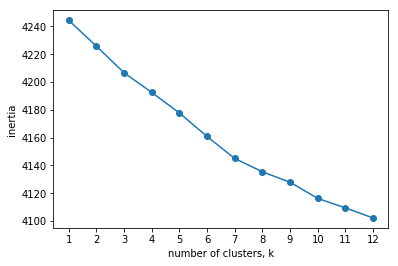

In [22]:
# Intertias
ks = range(1, 13)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(tfidf_train)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

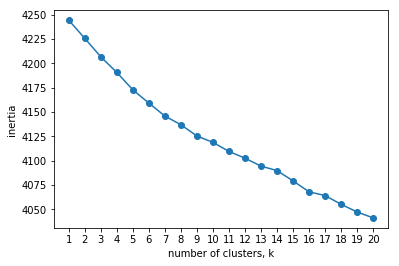

In [51]:
# Intertias
ks = range(1, 21)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(tfidf_train)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

## Experimenting with 6 clusters

In [23]:
km = KMeans(n_clusters=6)
    
# Fit model to samples
km.fit(tfidf_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [24]:
km.labels_

array([4, 1, 4, ..., 4, 3, 4], dtype=int32)

In [25]:
X_train[km.labels_ == 3].index

Int64Index([5017, 5243, 5072, 3626, 5272, 4903, 4808, 4762, 5054, 4741,
            ...
            5141, 4931, 5114, 5245, 4783,  167, 5230, 4870, 5009, 5077],
           dtype='int64', length=425)

In [26]:
df_news.iloc[X_train[km.labels_ == 3].index]['category'].value_counts()

4     335
5      30
8      11
3      11
1      11
2       8
7       6
10      5
9       5
6       3
Name: category, dtype: int64

## Adjusted Rand Index

In [27]:
km_6_pred = km.predict(tfidf_train)
metrics.adjusted_rand_score(y_train, km_6_pred)

0.12198237077552941

## 10 clusters

In [28]:
km_10 = KMeans(n_clusters=10)

# Fit model to samples
km_10.fit(tfidf_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [29]:
df_news.iloc[X_train[km_10.labels_ == 8].index]['category'].value_counts()

7    87
6    48
9    38
8    33
5     8
3     4
Name: category, dtype: int64

## Contingency tables

In [30]:
km_10_pred = km_10.predict(tfidf_train)
pd.crosstab(y_train, km_10_pred) 

col_0,0,1,2,3,4,5,6,7,8,9
category,,,,,,,,,,
1,17,0,46,112,2,1,268,0,0,0
2,23,0,137,176,47,1,0,0,0,61
3,151,0,71,90,11,113,4,1,4,0
4,53,41,66,130,155,0,0,0,0,0
5,73,9,181,145,20,1,1,5,8,0
6,54,0,86,42,1,202,0,10,48,0
7,46,0,106,78,3,10,2,110,87,0
8,250,0,69,41,9,36,0,0,33,0
9,38,0,249,48,5,2,0,54,38,0


## Adjusted Rand Index

In [31]:
metrics.adjusted_rand_score(y_train, km_10_pred)

0.11656692482877962

## SpectralClustering

In [112]:
n_clusters=10

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(tfidf_train)

#Predicted clusters.
predict_sc = sc.fit_predict(tfidf_train)

In [113]:
pd.crosstab(y_train, predict_sc) 

col_0,0,1,2,3,4,5,6,7,8,9
category,,,,,,,,,,
1,9,16,214,17,0,0,1,2,187,0
2,24,0,357,0,58,0,2,4,0,0
3,50,0,228,0,0,0,158,5,4,0
4,13,0,220,0,0,0,0,212,0,0
5,141,0,282,0,0,0,3,17,0,0
6,131,0,90,0,0,0,221,1,0,0
7,287,0,101,0,0,36,16,0,2,0
8,142,0,237,0,0,0,52,7,0,0
9,324,0,97,0,0,8,2,3,0,0


In [114]:
metrics.adjusted_rand_score(y_train, predict_sc)

0.09408574389739935

## Logistic Regression - BoW

In [32]:
# Instantiate
lr = LogisticRegression()

# Fit the classifier to the training data
lr.fit(count_train, y_train)

# Create the predicted tags: pred
pred = lr.predict(count_val)

print('Training set score:', lr.score(count_train, y_train))

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_val, pred)
print(f'\nTest set score: {score}')

# Calculate the confusion matrix: cm
pd.crosstab(y_val, pred)

Training set score: 1.0

Test set score: 0.8649584487534626


col_0,1,2,3,4,5,6,7,8,9,10
category,,,,,,,,,,
1,133,2,5,0,2,0,2,4,0,1
2,0,138,3,0,2,1,2,2,1,0
3,0,0,123,1,2,8,2,12,0,0
4,0,3,1,138,0,1,0,3,2,0
5,1,2,1,1,132,0,6,4,1,0
6,0,0,8,0,0,121,7,9,3,0
7,0,1,3,1,14,14,103,1,11,0
8,0,0,5,1,3,6,2,127,2,0
9,1,0,2,0,3,3,8,4,123,0


## Logistic Regression: TF-IDF

In [33]:
# Instantiate
lr = LogisticRegression()

# Fit the classifier to the training data
lr.fit(tfidf_train, y_train)

# Create the predicted tags: pred
pred = lr.predict(tfidf_val)

print('Training set score:', lr.score(tfidf_train, y_train))

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_val, pred)
print(f'\nTest set score: {score}')

# Calculate the confusion matrix: cm
pd.crosstab(y_val, pred)

Training set score: 0.9651270207852194

Test set score: 0.8732686980609419


col_0,1,2,3,4,5,6,7,8,9,10
category,,,,,,,,,,
1,134,1,2,1,1,1,1,7,0,1
2,0,137,1,3,2,0,2,3,0,1
3,0,0,117,5,2,10,3,10,1,0
4,0,4,1,140,1,0,0,2,0,0
5,1,0,0,2,135,0,4,4,2,0
6,0,0,6,0,3,124,6,8,1,0
7,0,0,3,0,5,13,110,4,13,0
8,0,0,7,0,3,2,3,130,1,0
9,0,0,0,0,7,2,9,5,120,1


In [111]:
# tfidf_df_train = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())
# tfidf_df_train['cluster_result'] = km_10.labels_
# tfidf_df_train.head()

In [112]:
# tfidf_df_train.shape

In [113]:
# # Instantiate
# lr = LogisticRegression()

# # Fit the classifier to the training data
# lr.fit(tfidf_df_train, y_train)

# # Create the predicted tags: pred
# pred = lr.predict(tfidf_df_train)

# print('Training set score:', lr.score(tfidf_df_train, y_train))

# # Calculate the accuracy score: score
# score = metrics.accuracy_score(y_val, pred)
# print(f'\nTest set score: {score}')

# # Calculate the confusion matrix: cm
# pd.crosstab(y_val, pred)

## Logistic Regression: TF-IDF GridSearch

In [75]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(tfidf_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.89
Best parameters:  {'C': 10}


## Logistic Regression: ngrams

In [77]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression()) # running the grid search takes a long time because of the
# relatively large grid and the inclusion of trigrams

param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10],
                  "tfidfvectorizer__ngram_range": [(1, 1), (1, 2)]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.89
Best parameters:
{'logisticregression__C': 10, 'tfidfvectorizer__ngram_range': (1, 2)}


## Random Forest

In [94]:
rfc = ensemble.RandomForestClassifier(n_estimators=100, n_jobs=-1)
rfc.fit(tfidf_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [95]:
# Create the predicted tags: pred
pred = rfc.predict(tfidf_val)

print('Training set score:', rfc.score(tfidf_train, y_train))

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_val, pred)
print(f'\nTest set score: {score}')

Training set score: 1.0

Test set score: 0.824792243767313


## Random Forest: GridSearch

In [96]:
parameters = {'n_estimators':[100,300,500],
              'max_features':['sqrt', 'log2'],
              'min_samples_split':[2,8,20]
             }

# Instantiating and fitting Grid Search, then printing best score and best parameters
grid_rfc = GridSearchCV(ensemble.RandomForestClassifier(), param_grid=parameters, cv=5, n_jobs=2)
grid_rfc.fit(tfidf_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'n_estimators': [100, 300, 500], 'max_features': ['sqrt', 'log2'], 'min_samples_split': [2, 8, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [97]:
print("Best cross-validation score: {:.2f}".format(grid_rfc.best_score_))
print("Best parameters:\n{}".format(grid_rfc.best_params_))

Best cross-validation score: 0.88
Best parameters:
{'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 500}


## Test Set

In [91]:
# Instantiate
lr_final = LogisticRegression(C=10, multi_class='ovr')

# Fit the classifier to the training data
lr_final.fit(tfidf_train, y_train)

pred_test = lr_final.predict(tfidf_test)

# Calculate the accuracy score: score
score_test = metrics.accuracy_score(y_test, pred_test)
print(f'\nTest set score: {score_test}')


Test set score: 0.8171175858480749


In [79]:
# Confusion matrix
pd.crosstab(y_test, pred_test)

col_0,1,2,3,4,5,6,7,8,9,10
category,,,,,,,,,,
1,360,1,3,1,7,3,2,6,5,8
2,1,345,6,3,12,4,5,7,3,10
3,0,1,297,3,4,31,7,47,5,0
4,0,8,2,361,5,1,0,10,2,5
5,7,7,0,4,316,10,29,10,10,0
6,3,3,23,3,3,281,28,24,19,7
7,0,1,8,4,24,30,276,13,35,1
8,4,5,19,7,16,14,9,304,10,1
9,0,1,2,1,15,9,27,7,322,1


## Clustering Test Set

In [131]:
km_10_test = KMeans(n_clusters=10)

# Fit model to samples
km_10_test.fit(tfidf_test)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [140]:
df_news_test.iloc[X_test[km_10_test.labels_ == 9].index]['category'].value_counts()

8     47
3     46
5     28
1     24
6     15
7     14
2     12
4     11
9      8
10     4
Name: category, dtype: int64

In [132]:
km_10_pred_test = km_10.predict(tfidf_test)
pd.crosstab(y_test, km_10_pred_test) 

col_0,0,1,2,3,4,5,6,8,9
category,,,,,,,,,
1,0,134,22,1,1,1,84,0,153
2,3,244,11,1,1,0,136,0,0
3,1,7,58,84,9,3,230,0,3
4,2,142,13,0,154,0,82,1,0
5,0,36,21,0,9,5,313,6,3
6,7,20,33,174,1,41,104,13,1
7,9,11,15,5,3,72,204,73,0
8,4,13,120,2,5,18,227,0,0
9,7,6,6,1,3,35,284,43,0


In [134]:
metrics.adjusted_rand_score(y_test, km_10_pred_test)

0.11710507071345574

# --- Testing ---

In [34]:
tfidf_df_train = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())
tfidf_df_train.head()

,aa,aaron,aau,ab,abandon,abandoned,abc,abiding,ability,able,...,zoo,zoology,zoom,zq,zr,zrepachol,zt,zurich,zyeh,zz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04366,0.031797,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.048748,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
tfidf_df_train.columns

Index(['aa', 'aaron', 'aau', 'ab', 'abandon', 'abandoned', 'abc', 'abiding',
       'ability', 'able',
       ...
       'zoo', 'zoology', 'zoom', 'zq', 'zr', 'zrepachol', 'zt', 'zurich',
       'zyeh', 'zz'],
      dtype='object', length=10252)

### chi2

In [61]:
convert_cat = []
to_drop = []

categorical = tfidf_df_train.columns

for index, feature in enumerate(categorical):

    cont = pd.crosstab(tfidf_df_train[feature], y_train, colnames=[None])
    chi2_res = scipy.stats.chi2_contingency(cont)

    # Keep all features with a significant P-value and drop the others
    if chi2_res[1] <= 0.05:
        convert_cat.append(feature)
    else:
        to_drop.append(feature)

/Users/rook/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/pivot.py:135: FutureWarning: 'None' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  grouped = data.groupby(keys)


In [62]:
print(f'convert_cat len: {len(convert_cat)}')
print(f'to_drop len: {len(to_drop)}')

convert_cat len: 523
to_drop len: 9729


In [63]:
# Drop cols
X_chi2 = tfidf_df_train.loc[:, ~tfidf_df_train.columns.isin(to_drop)]

In [64]:
X_chi2.values

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

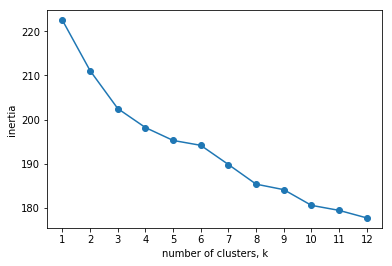

In [67]:
# Intertias
ks = range(1, 13)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(X_chi2)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [75]:
km_chi2 = KMeans(n_clusters=6)
    
# Fit model to samples
km_chi2.fit(X_chi2)

km_chi2_pred = km_chi2.predict(X_chi2)
metrics.adjusted_rand_score(y_train, km_chi2_pred)

0.008503493090740295

In [76]:
# Instantiate
lr_tester = LogisticRegression()

# Fit the classifier to the training data
lr_tester.fit(X_chi2.values, y_train)

print('Training set score:', lr_tester.score(X_chi2.values, y_train))

Training set score: 0.3995381062355658


Much worse.

### variance_threshold_selector

In [68]:
# Removes all low-variance features
def variance_threshold_selector(data, threshold=0.0005):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

vt_to_keep = variance_threshold_selector(tfidf_df_train)

vt_to_keep.head()

,ac,accelerator,access,address,ai,alaska,algorithm,amanda,andrew,apple,...,vlb,vram,washington,water,widget,window,work,world,wpi,xterm
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02792,0.0,0.0
1,0.0,0.0,0.095206,0.0,0.0,0.0,0.052242,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0


In [69]:
vt_to_keep.shape

(4330, 256)

In [70]:
X_vt = tfidf_df_train[vt_to_keep.columns]

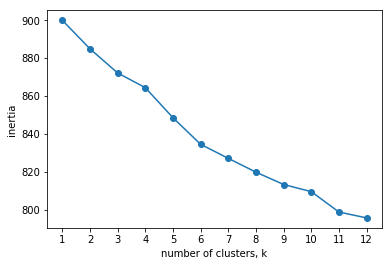

In [71]:
# Intertias
ks = range(1, 13)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(X_vt)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [55]:
# Instantiate
lr_tester = LogisticRegression()

# Fit the classifier to the training data
lr_tester.fit(X.values, y_train)

print('Training set score:', lr_tester.score(X.values, y_train))

Training set score: 0.7468822170900693


In [49]:
tfidf_df_train.shape

(4330, 10252)

In [2]:
correlation_matrix = tfidf_df_train.corr()
display(correlation_matrix)

In [ ]:
# Correlated features to be dropped
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
print(f'Number of correlated features to drop: {len(to_drop)}')